This notebook shows how to build a map for a new raster stack or region using a pretrained model.

In [1]:
from sri_maper.src.utils import build_hydra_config_notebook, print_config_tree
from sri_maper.src.map import build_map
from torch import set_float32_matmul_precision

set_float32_matmul_precision('medium') # reduces floating point precision for computational efficiency

Presumably, you might have trained some MPM classifiers (ResNet or MAE) using the `resnet_demo.ipynb`, `mae_demo.ipynb`, or command line interface (suggested method). If not, you can gain access to pretrained checkpoints SRI TA3 has available in a Sharepooint website by emailing Angel Daruna (`angel.daruna@sri.com`) or Vasily Zadorozhnyy (`vasily.zadorozhnyy@sri.com`). We cannot make a public link.

Below both MAE and ResNet classifiers are used to build maps for a small area of the MaNiAC problem presented at Hackathon 2. The original MaNiAC challenged was a Magmatic Nickel CMA at national-scale for the conterminous US. We have prepared a new set of rasters to show how one can readily use the existing repo to build new maps with pretrained models. These example rasters cover a small region of the Magmantic Nickel CMA - in Montana by Yellowstone. Note, as long as the new raster data include all the evidence layers used in the trained classifier, one could perform inference in a completely new region (e.g. Canada).

The first step to building a map for a new raster stack or region is to write a preprocessing config file for that raster stack. For the subset of the MaNiAC CMA mentioned above (i.e. MaNiAC mini from here on) we have prepared an example config titled [maniac-mini.yaml](../configs/preprocess/maniac-mini.yaml). Look carefully at the `maniac-mini.yaml` preprocess config - it details how the multi-band raster stack is composed by listing the component rasters and their types. Note, these component rasters and types match exactly too `maniac-natl.yaml`, which our classifiers were trained on although the raster regions differ. Hence, we can apply those same trained models to this new raster stack for mapping. Technically, one can apply the trained models to any raster stack that matches the expected dimensionality of the trained models, but predictions wouldn't necessarily be meaningful (e.g. train on magnetics and test with geology). Ensuring that the evidence layers (and their order) comprising the raster stack used for mapping matches the one used for training will allow for meaningful predictions / maps being output.

Let's load and print the experiment configuration to build a map for the MaNiAC mini raster stack.

In [2]:
maniac_mini_resnet_map_cfg = build_hydra_config_notebook(
    overrides=[
        "experiment=exp_maniac_resnet_l22_uscont", # this experiment config as it applies to MaNiAC mini - if it didn't, we would just write one that did
        "trainer=gpu", # we'll use a single GPU b/c we're in a notebook file
        "preprocess=maniac-mini", # we'll want to use a different raster stack - the MaNiAC mini one
        "data.tif_dir=${paths.data_dir}/H3/MaNiAC_mini", # we'll want to save that raster stack to a different folder
        "ckpt_path=${paths.log_dir}/cmta3-train-all-l22/runs/2024-03-26_17-39-37/checkpoints/auprc_0.864.ckpt", # you should OVERRIDE this with a path to your checkpoint!!
        "data.batch_size=128" # this slightly speeds up mapping
    ]
)
print_config_tree(maniac_mini_resnet_map_cfg)

CONFIG
├── data
│   └── _target_: sri_maper.src.data.tiff_datamodule.TIFFDataModule                                                
│       tif_dir: ${paths.data_dir}/H3/MaNiAC_mini                                                                  
│       window_size: 33                                                                                            
│       multiplier: 20                                                                                             
│       downsample: true                                                                                           
│       oversample: true                                                                                           
│       likely_neg_range:                                                                                          
│       - 0.75                                                                                                     
│       - 1.0                                                                                                      
│       batch_size: 128                                                                                            
│       num_workers: 12                                                                                            
│       pin_memory: false                                                                                          
│       seed: ${seed}                                                                                              
│       log_path: ${paths.output_dir}                                                                              
│                                                                                                                  
├── model
│   └── _target_: sri_maper.src.models.cma_module.CMALitModule                                                     
│       optimizer:                                                                                                 
│         _target_: torch.optim.AdamW                                                                              
│         _partial_: true                                                                                          
│         lr: 0.001                                                                                                
│         weight_decay: 0.01                                                                                       
│       scheduler:                                                                                                 
│         _target_: torch.optim.lr_scheduler.ReduceLROnPlateau                                                     
│         _partial_: true                                                                                          
│         mode: min                                                                                                
│         factor: 0.1                                                                                              
│         patience: 10                                                                                             
│       net:                                                                                                       
│         _target_: sri_maper.src.models.resnet.ResNet                                                             
│         num_input_channels: 14                                                                                   
│         num_output_classes: 1                                                                                    
│         dropout_rate: 0.5                                                                                        
│       compile: false                                                                                             
│       gain: 1.0                                                                                                  
│       mc_samples: 100       

Note - we provide a new folder for the new raster stack. If we used an existing folder, than that raster stack would be cosidered as part of any other raster stacks in that folder that together comprise a raster stack dataset. This feature is useful (although not in this case) when training, testing, mapping, etc on regions that cannot be neatly put in a single raster (e.g. non-contiguous like training on USA and Australia data).

With the experiment config for ResNet mapping defined, we can now generate the maps. Note - the `build_map` task preprocess the raster stack to generate it if it doesn't exist already, then builds the map.

In [3]:
maniac_mini_resnet_maps, resnet_objs = build_map(maniac_mini_resnet_map_cfg)
del resnet_objs # clears GPU

100%|██████████| 1/1 [00:00<00:00, 456.60it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
wandb: Currently logged in as: adaruna3. Use `wandb login --relogin` to force relogin


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

We can repeat the above for a train MAE model too...

In [4]:
maniac_mini_mae_map_cfg = build_hydra_config_notebook(
    overrides=[
        "experiment=exp_maniac_maevit_classifier_l22_uscont", # this experiment config as it applies to MaNiAC mini - if it didn't, we would just write one that did
        "trainer=gpu", # we'll use a single GPU b/c we're in a notebook file
        "preprocess=maniac-mini", # we'll want to use a different raster stack - the MaNiAC mini one
        "data.tif_dir=${paths.data_dir}/H3/MaNiAC_mini", # we'll want to save that raster stack to a different folder
        "model.net.backbone_ckpt=${paths.log_dir}/cmta3-pretrain-maevit/runs/2024-03-26_21-04-46/checkpoints/ssim_0.927.ckpt", # you should OVERRIDE this path to your pretrain checkpoint!!
        "ckpt_path=${paths.log_dir}/cmta3-classifier-maevit/runs/2024-03-26_21-56-10/checkpoints/auprc_0.896.ckpt", # you should OVERRIDE this with a path to your checkpoint!!
        "data.batch_size=64" # this slightly speeds up mapping
    ]
)
maniac_mini_mae_maps, mae_objs = build_map(maniac_mini_mae_map_cfg)
del mae_objs

100%|██████████| 1/1 [00:00<00:00, 883.57it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Optionally, we can directly plot these produced maps. For example, below we plot the likelihoods.

In [5]:
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path

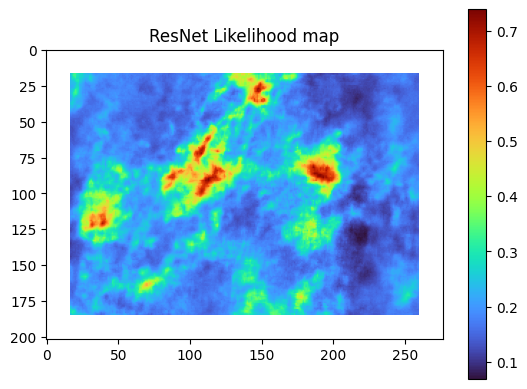

In [7]:
with rasterio.open(maniac_mini_resnet_maps[0], "r") as likelihood_raster:
    likelihood_data = likelihood_raster.read(1)
plt.imshow(likelihood_data, cmap="turbo")
plt.title("ResNet Likelihood map")
plt.colorbar()
plt.show()

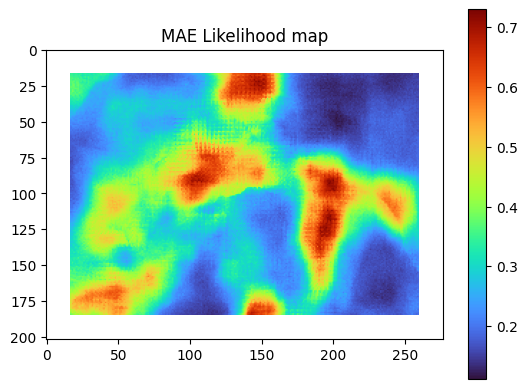

In [8]:
with rasterio.open(maniac_mini_mae_maps[0], "r") as likelihood_raster:
    likelihood_data = likelihood_raster.read(1)
plt.imshow(likelihood_data, cmap="turbo")
plt.title("MAE Likelihood map")
plt.colorbar()
plt.show()